In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from custom_models.dcgan import DCGANDiscriminator, DCGANGenerator, weights_init
import torch
import torch.nn as nn
from utils import load_medMNIST_data
import seaborn as sns
sns.set(style="whitegrid", context="notebook",)

In [39]:
dataloader, dataset = load_medMNIST_data()

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Image size: torch.Size([3, 28, 28])
Label size: torch.Size([1])
Label values: {0, 1, 2, 3, 4, 5, 6, 7}


In [40]:
# get image size from the dataset
channels, dim_1, dim_2 = dataloader.dataset[0][0].shape

print(f"Channels: {channels}")
print(f"Dim 1: {dim_1}")
print(f"Dim 2: {dim_2}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Channels: 3
Dim 1: 28
Dim 2: 28


In [41]:
# ********** Training parameters **********
loss_fn = nn.BCEWithLogitsLoss()
optimizer_class = torch.optim.Adam
D_lr = 0.001
G_lr = 0.001

z_dimension = 100

# ********** Discriminator **********
discriminator = DCGANDiscriminator(inputChannels=channels).to(device)
discriminator.apply(weights_init)
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=D_lr, betas=(0.5, 0.999))

# ********** Generator **********
generator = DCGANGenerator(inputDim=z_dimension, outputChannels=channels).to(device)
generator.apply(weights_init)
optimizerG = torch.optim.Adam(generator.parameters(), lr=G_lr, betas=(0.5, 0.999))


In [42]:
# Shape verification test
def test_shapes():
    z = torch.randn(128, z_dimension, 1, 1).to(device)
    img = torch.randn(128, channels, dim_1, dim_2).to(device)
    
    # Test generator
    gen_out = generator(z)
    print(f"Generator output: {gen_out.shape} (should be [128, {channels}, {dim_1}, {dim_2}]")
    
    # Test discriminator
    disc_out = discriminator(img)
    print(f"Discriminator output: {disc_out.shape} (should be [128])")
    
test_shapes()

Generator output: torch.Size([128, 3, 28, 28]) (should be [128, 3, 28, 28]
Discriminator output: torch.Size([128]) (should be [128])


Starting Training Loop...
Data range: min=-0.9686274528503418, max=1.0
[0/40][0/134] Loss_D: 1.4077 Loss_G: 0.6349
[0/40][70/134] Loss_D: 0.9790 Loss_G: 1.0130
Epoch 0 generated images:


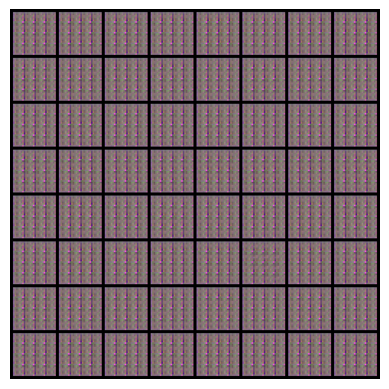

[1/40][0/134] Loss_D: 0.9818 Loss_G: 1.0888
[1/40][70/134] Loss_D: 0.8004 Loss_G: 1.2552
[2/40][0/134] Loss_D: 0.7347 Loss_G: 1.5957
[2/40][70/134] Loss_D: 0.7026 Loss_G: 1.7120
[3/40][0/134] Loss_D: 0.6871 Loss_G: 1.7892
[3/40][70/134] Loss_D: 1.3307 Loss_G: 1.6524
[4/40][0/134] Loss_D: 0.6854 Loss_G: 1.7150
[4/40][70/134] Loss_D: 0.6851 Loss_G: 1.7358
[5/40][0/134] Loss_D: 0.7677 Loss_G: 1.5569
[5/40][70/134] Loss_D: 1.1665 Loss_G: 1.6317
Epoch 5 generated images:


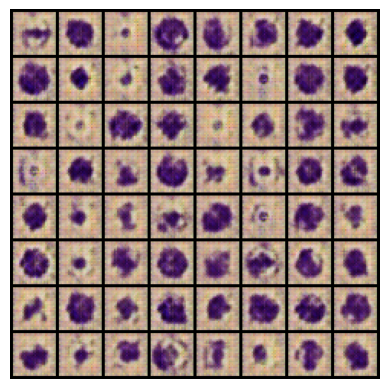

[6/40][0/134] Loss_D: 1.0816 Loss_G: 0.8405
[6/40][70/134] Loss_D: 1.5932 Loss_G: 1.3414
[7/40][0/134] Loss_D: 1.2473 Loss_G: 0.9455
[7/40][70/134] Loss_D: 1.2479 Loss_G: 0.9695
[8/40][0/134] Loss_D: 1.2277 Loss_G: 1.2770
[8/40][70/134] Loss_D: 1.2577 Loss_G: 1.3585
[9/40][0/134] Loss_D: 1.0990 Loss_G: 1.0335
[9/40][70/134] Loss_D: 1.3016 Loss_G: 1.1724
[10/40][0/134] Loss_D: 1.4951 Loss_G: 1.4105
[10/40][70/134] Loss_D: 1.1537 Loss_G: 1.0502
Epoch 10 generated images:


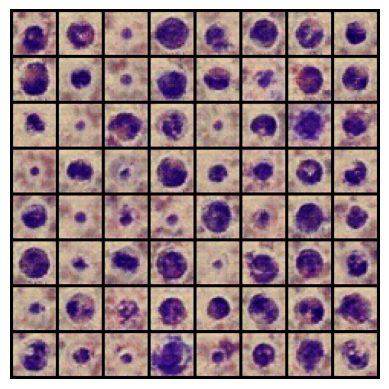

[11/40][0/134] Loss_D: 1.2719 Loss_G: 0.9773
[11/40][70/134] Loss_D: 1.1831 Loss_G: 1.0100
[12/40][0/134] Loss_D: 1.1139 Loss_G: 0.9741
[12/40][70/134] Loss_D: 1.1908 Loss_G: 0.8366
[13/40][0/134] Loss_D: 1.1918 Loss_G: 0.9098
[13/40][70/134] Loss_D: 1.1840 Loss_G: 0.9584
[14/40][0/134] Loss_D: 1.1745 Loss_G: 0.8660


In [ ]:
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils

# Training parameters
num_epochs = 40
batch_size = 128
nz = z_dimension  # Size of latent vector

# Training parameters
real_label = 0.9  # Soft label for real images
fake_label = 0.1  # Soft label for fake images
# Use 64 for consistent visualization
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Lists to track progress
G_losses = []
D_losses = []
img_list = []


def gradient_penalty(discriminator, real_samples, fake_samples, device):
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolates = alpha * real_samples + (1 - alpha) * fake_samples
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(d_interpolates, interpolates,
                                    grad_outputs=torch.ones_like(
                                        d_interpolates),
                                    create_graph=True, retain_graph=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


print("Starting Training Loop...")
# Updated training loop with stabilization techniques

# Add before training loop
sample, _ = next(iter(dataloader))
print(f"Data range: min={sample.min().item()}, max={sample.max().item()}")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update Discriminator
        ############################
        discriminator.zero_grad()

        # Prepare real images
        real_images = data[0].to(device)
        real_images = real_images * 2.0 - 1.0
        batch_size = real_images.size(0)

        # Train with real images
        real_labels = torch.full((batch_size,), real_label, device=device, dtype=torch.float)
        output_real = discriminator(real_images)
        errD_real = loss_fn(output_real, real_labels)
        errD_real.backward()

        # Train with fake images - CREATE NEW NOISE AND FAKE IMAGES
        noise_d = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images_d = generator(noise_d)
        fake_labels = torch.full((batch_size,), fake_label, device=device, dtype=torch.float)
        output_fake = discriminator(fake_images_d.detach())
        errD_fake = loss_fn(output_fake, fake_labels)
        errD_fake.backward()

        # Gradient penalty with the same fake images
        gp = gradient_penalty(discriminator, real_images, fake_images_d, device)
        errD = errD_real + errD_fake #+ gp * 10.0  # Weight GP loss
        optimizerD.step()

        ############################
        # (2) Update Generator
        ############################
        for _ in range(1):
            generator.zero_grad()
            
            # CREATE FRESH NOISE AND FAKE IMAGES FOR GENERATOR
            noise_g = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images_g = generator(noise_g)
            
            output = discriminator(fake_images_g)
            real_labels = torch.full((batch_size,), real_label, device=device, dtype=torch.float)
            errG = loss_fn(output, real_labels)
            errG.backward()
            optimizerG.step()

        # Store losses
        G_losses.append(errG.item())
        D_losses.append(errD.item() if isinstance(
                errD, torch.Tensor) else errD)

        # Print stats
        if i % 70 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item() if isinstance(errD, torch.Tensor) else errD:.4f} Loss_G: {errG.item():.4f}')

    # Generate and store images
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        img_list.append(vutils.make_grid(
            fake_images, padding=2, normalize=True))

    # plot sample images
    if epoch % 5 == 0:
        print(f'Epoch {epoch} generated images:')
        plt.imshow(img_list[-1].cpu().numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.show()

print("Training Complete!")

In [ ]:
# plot from fixed noise
import matplotlib.pyplot as plt

output_images = generator(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images from Fixed Noise Last Epoch")
plt.imshow(vutils.make_grid(output_images, padding=2, normalize=True).permute(1, 2, 0))
plt.show()

In [ ]:
# display generated images
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to display generated images
def show_generated_images(generator, nz, num_images=49, device=device):
    # Generate fresh images
    with torch.no_grad():
        # Create batch of latent vectors
        noise = torch.randn(num_images, nz, 1, 1, device=device)
        # Generate fake images
        fake_images = generator(noise)
    
    # Create a grid with WHITE padding (pad_value=1.0)
    grid = vutils.make_grid(fake_images, nrow=7, padding=2, normalize=True, pad_value=1.0)
    
    # Display the image
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Show exactly 25 newly generated images with white padding
show_generated_images(generator, nz=z_dimension)

In [ ]:
#plot the loss curves
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Function to plot loss curves with enhanced styling
def plot_loss_curves(G_losses, D_losses):
    # Set the aesthetic style
    sns.set(style="whitegrid", context="notebook")
    
    # Format the loss data
    iterations = np.arange(1, len(G_losses) + 1)
    loss_df = pd.DataFrame({
        'Iteration': iterations,
        'Generator': G_losses,
        'Discriminator': D_losses
    })
    
    plt.figure(figsize=(8, 5), dpi=300)
    
    ax = sns.lineplot(
        data=loss_df,
        x='Iteration',
        y='Generator',
        label='Generator',
        color='blue',
        linewidth=2,
    )
    
    sns.lineplot(
        data=loss_df,
        x='Iteration',
        y='Discriminator',
        label='Discriminator',
        color='red',
        linewidth=2,
    )
    
    plt.title("Generator and Discriminator Loss During Training", fontweight="bold", fontsize=14)
    plt.xlabel("Iteration", fontweight="bold")
    plt.ylabel("Loss", fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()

# Call the function with your loss data
plot_loss_curves(G_losses, D_losses)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, ConcatDataset
# **************************************
# Wrapper to use pytorch_fid's fid_score() with in-memory images
import pytorch_fid_wrapper as pfw

N_EVAL_SAMPLES = 10000

# Generate samples from the generator
def generate_samples(generator, num_samples=N_EVAL_SAMPLES, z_dim=64):
    generator.eval()  # Set to evaluation mode
    with torch.no_grad():
        noise = torch.randn(num_samples, z_dim, 1, 1).to(device)
        generated_images = generator(noise)
    return generated_images

def get_fid(synthetic_samples):
    random_sampler = RandomSampler(
                dataloader, num_samples=N_EVAL_SAMPLES)

    eval_dataloader = DataLoader(
                dataset=dataset, batch_size=128, sampler=random_sampler)
    eval_tensor = torch.cat(
                [batch[0] for batch in eval_dataloader], dim=0)


    # 4. Compute Frechet Inception Distance (FID) between real and synthetic
    pfw.set_config(batch_size=10, dims=2048, device="cuda" if torch.cuda.is_available() else "cpu")
    # print(f"Real samples shape: {eval_tensor.shape}")
    # print(f"Fake samples shape: {synthetic_samples.shape}"
    fid = pfw.fid(fake_images=synthetic_samples,
                real_images=eval_tensor)
    print(f"FID:{fid}")
    
    return fid


In [ ]:
import random

import numpy as np


EVAL_SEEDS = [100, 200, 300, 400, 500]


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
    
    
fid_scores = []

for seed in EVAL_SEEDS:
    set_seed(seed)   
    synthetic_samples = generate_samples(generator, num_samples=N_EVAL_SAMPLES, z_dim=z_dimension) 
    fid_score = get_fid(synthetic_samples)
    print(f"FID score for seed {seed}: {fid_score}")
    fid_scores.append(fid_score)
    
    

In [ ]:
# Calculate the average FID score
average_fid = np.mean(fid_scores)
std_fid = np.std(fid_scores)
print(f"FID scores: {fid_scores}")
print(f"Average FID score: {average_fid:.4f} ± {std_fid:.4f} (over {len(EVAL_SEEDS)} seeds)")